# Bidirectional Delta-Neutral Funding Rate Carry
**QTS Final Project — Exploratory Analysis**

Universe: BTCUSDT · ETHUSDT · SOLUSDT · BNBUSDT · XRPUSDT · DOGEUSDT · AVAXUSDT  
Period: Sep 2020 – Feb 2026  |  8-hour rebalance  |  Binance USDT-M perps

In [3]:
import sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')
sys.path.insert(0, '.')          # so 'import strategy' works from the repo root
from strategy import (
    run_backtest, funding_zscore, oi_filter, macro_gate,
    compute_positions, compute_pnl, compute_metrics,
    UNIVERSE, DEFAULTS, PERIODS_PER_YEAR,
)

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.35,
    'font.size': 10,
})
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# ── Load master panel ─────────────────────────────────────────────────────────
panel = pd.read_parquet('data/processed/master_panel.parquet')

# Forward-fill VIX nulls (holidays / Jan 1 gaps)
vix_wide = panel['vix_close'].unstack('symbol')
vix_ffilled = vix_wide.ffill()
panel = panel.copy()
panel['vix_close'] = vix_ffilled.stack().reindex(panel.index)

print(f'Panel shape  : {panel.shape}')
print(f'Date range   : {panel.index.get_level_values("datetime").min().date()} '
      f'→ {panel.index.get_level_values("datetime").max().date()}')
print(f'Symbols      : {sorted(panel.index.get_level_values("symbol").unique().tolist())}')
print(f'Null counts  :\n{panel.isnull().sum()}')

Panel shape  : (101115, 11)
Date range   : 2020-01-01 → 2026-02-24
Symbols      : ['ADAUSDT', 'ARBUSDT', 'ATOMUSDT', 'AVAXUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'ETHUSDT', 'LINKUSDT', 'LTCUSDT', 'POLUSDT', 'SOLUSDT', 'UNIUSDT', 'XRPUSDT']
Null counts  :
funding_rate         12681
perp_open            12726
perp_high            12726
perp_low             12726
perp_close           12726
perp_volume          12726
spot_close           11620
open_interest        26811
vix_close               45
spy_close             3600
rfr_daily_decimal        0
dtype: int64


In [5]:
# ── Run baseline backtest (no OBI — data not yet fetched) ────────────────────
BASE = run_backtest(panel, use_obi=False)

print('Baseline metrics:')
for k, v in BASE['metrics'].items():
    print(f'  {k:<20} {v}')

Baseline metrics:
  cagr                 -0.0244
  ann_vol              0.0138
  sharpe               -7.549
  sortino              -15.583
  max_drawdown         0.3233
  hit_rate             0.1344
  avg_win              0.000613
  avg_loss             -0.000342
  profit_factor        0.786
  n_periods            6741
  n_years              6.16


---
## Analysis 1 — Basic Performance
Gross (no transaction costs) vs net (taker fees + RFR credit).  
Monthly heatmap, P&L decomposition, and break-even cost estimate.

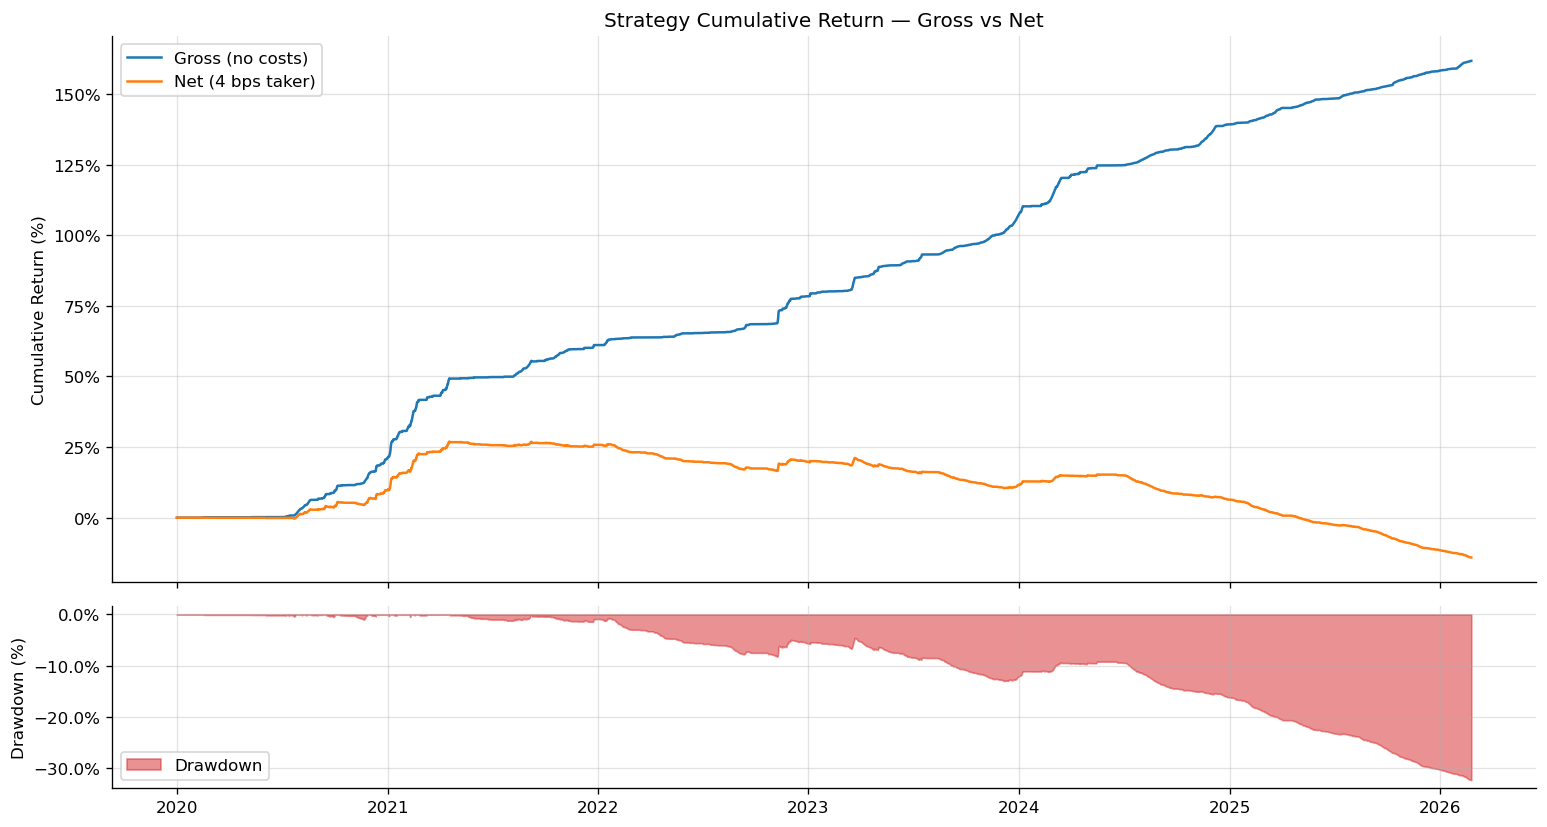

,CAGR,Ann Vol,Sharpe,Sortino,Max DD,Hit Rate,Prof Factor
Scenario,,,,,,,
Gross,16.9%,1.4%,5.32,29.61,0.3%,31.7%,118.82
Net,-2.4%,1.4%,-7.55,-15.58,32.3%,13.4%,0.79


In [6]:
GROSS = run_backtest(panel, use_obi=False, taker_fee=0.0)
NET   = BASE   # taker_fee = 0.0004 (4 bps)

fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True,
                          gridspec_kw={'height_ratios': [3, 1]})

ax = axes[0]
ax.plot(GROSS['cum_returns'].index, GROSS['cum_returns'].values * 100,
        label='Gross (no costs)', lw=1.5, color=COLORS[0])
ax.plot(NET['cum_returns'].index, NET['cum_returns'].values * 100,
        label='Net (4 bps taker)', lw=1.5, color=COLORS[1])
ax.set_ylabel('Cumulative Return (%)')
ax.set_title('Strategy Cumulative Return — Gross vs Net')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Drawdown
ax2 = axes[1]
cum = (1 + NET['pnl']['total_pnl'].fillna(0)).cumprod()
dd  = (cum.cummax() - cum) / cum.cummax() * 100
ax2.fill_between(dd.index, 0, -dd.values, alpha=0.5, color=COLORS[3], label='Drawdown')
ax2.set_ylabel('Drawdown (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend()

plt.tight_layout()
plt.show()

# Metrics table
rows = []
for label, res in [('Gross', GROSS), ('Net', NET)]:
    m = res['metrics']
    rows.append({
        'Scenario': label,
        'CAGR': f"{m['cagr']:.1%}",
        'Ann Vol': f"{m['ann_vol']:.1%}",
        'Sharpe': f"{m['sharpe']:.2f}",
        'Sortino': f"{m['sortino']:.2f}",
        'Max DD': f"{m['max_drawdown']:.1%}",
        'Hit Rate': f"{m['hit_rate']:.1%}",
        'Prof Factor': f"{m['profit_factor']:.2f}",
})
display(pd.DataFrame(rows).set_index('Scenario'))

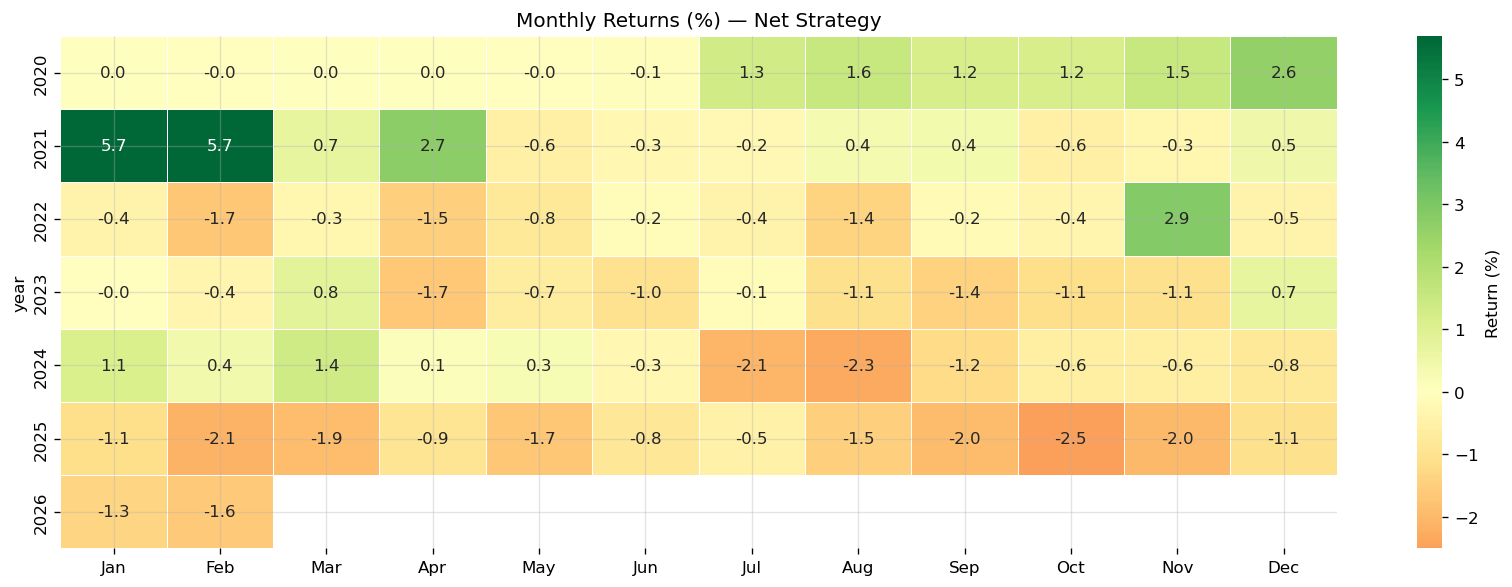

In [7]:
# ── Monthly returns heatmap ───────────────────────────────────────────────────
pnl_net = NET['pnl']['total_pnl'].fillna(0)
pnl_net.index = pd.to_datetime(pnl_net.index)

# Compound within each calendar month
monthly = pnl_net.resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
pivot   = monthly.copy()
pivot   = pd.DataFrame({
    'year':  pivot.index.year,
    'month': pivot.index.month,
    'ret':   pivot.values,
})
heat = pivot.pivot(index='year', columns='month', values='ret')
heat.columns = ['Jan','Feb','Mar','Apr','May','Jun',
                'Jul','Aug','Sep','Oct','Nov','Dec'][:len(heat.columns)]

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(heat, annot=True, fmt='.1f', center=0,
            cmap='RdYlGn', linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Return (%)'})
ax.set_title('Monthly Returns (%) — Net Strategy')
plt.tight_layout()
plt.show()

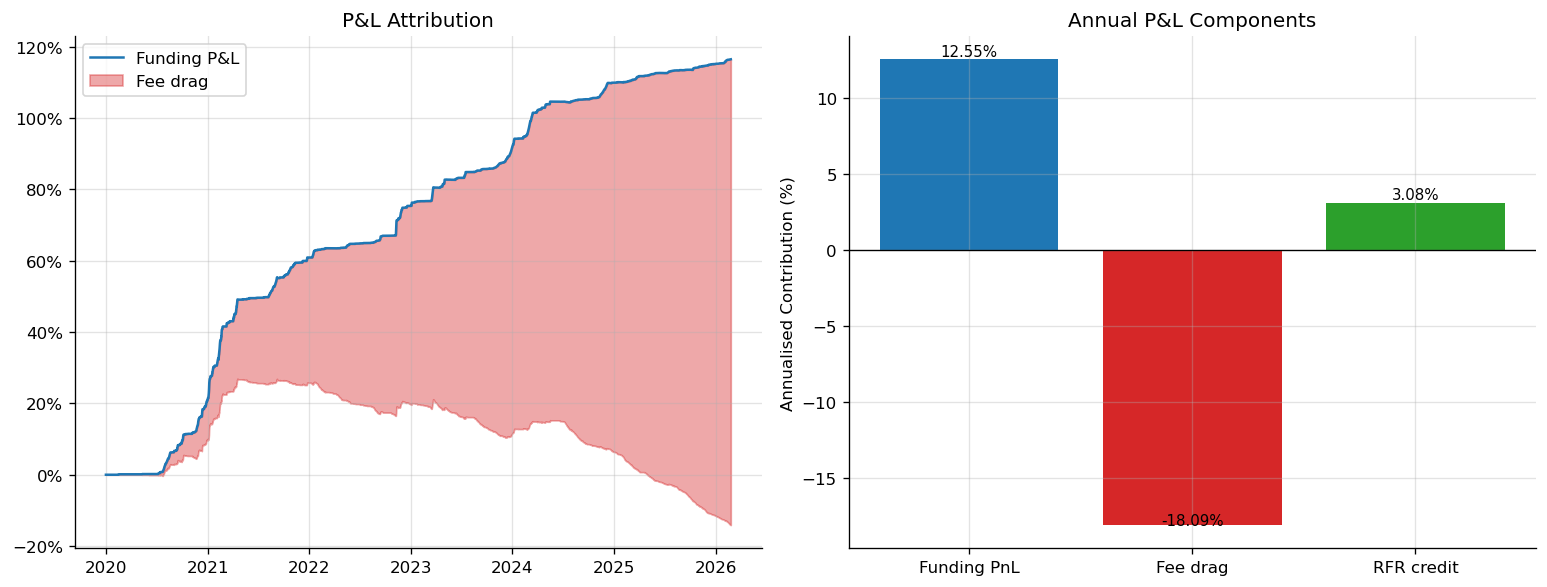

Average turnover per period : 0.4132
Break-even taker fee        : 2.8 bps  (current: 4 bps)


In [8]:
# ── P&L decomposition & break-even cost ──────────────────────────────────────
pnl = NET['pnl'].fillna(0)

# Annualised contribution of each component
components = {
    'Funding PnL':    pnl['funding_pnl'],
    'Fee drag':       pnl['fee_pnl'],
    'RFR credit':     pnl['rfr_pnl'],
}
ann_contrib = {k: v.sum() / NET['metrics']['n_years'] * 100 for k, v in components.items()}

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Stacked area
ax = axes[0]
cum_fund = (1 + pnl['funding_pnl']).cumprod() - 1
cum_fee  = (1 + pnl['total_pnl']).cumprod() - 1 - cum_fund
ax.plot(pnl.index, cum_fund.values * 100, label='Funding P&L', color=COLORS[0])
ax.fill_between(pnl.index, (cum_fund + cum_fee).values * 100,
                cum_fund.values * 100, alpha=0.4, color=COLORS[3], label='Fee drag')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('P&L Attribution')
ax.legend()

# Bar: annualised contribution
ax2 = axes[1]
bars = ax2.bar(ann_contrib.keys(), ann_contrib.values(),
               color=[COLORS[0], COLORS[3], COLORS[2]])
ax2.axhline(0, color='black', lw=0.8)
ax2.set_ylabel('Annualised Contribution (%)')
ax2.set_title('Annual P&L Components')
for bar, v in zip(bars, ann_contrib.values()):
    ax2.text(bar.get_x() + bar.get_width()/2, v + (0.05 if v >= 0 else -0.2),
             f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Break-even taker fee
avg_turnover = pnl['fee_pnl'].abs().sum() / (DEFAULTS['taker_fee'] + 1e-12) / len(pnl)
gross_per_period = pnl['funding_pnl'].mean()
be_fee = gross_per_period / avg_turnover if avg_turnover > 0 else np.nan
print(f'Average turnover per period : {avg_turnover:.4f}')
print(f'Break-even taker fee        : {be_fee*10000:.1f} bps  (current: 4 bps)')

---
## Analysis 2 — Three-Signal Comparison
| Signal | Description |
|--------|-------------|
| **A** — z-score | `(rate − rolling_mean) / rolling_std`  ← baseline |
| **B** — level   | `rate / rolling_std`  (no mean subtraction: bets on absolute level) |
| **C** — momentum | `EMA₉(Δrate) / rolling_std`  (bets on direction of change) |

In [9]:
def signal_b(funding: pd.DataFrame, lookback: int = 270) -> pd.DataFrame:
    """Raw level: funding / rolling_std — no mean subtraction."""
    min_obs = max(lookback // 2, 2)
    std = funding.rolling(lookback, min_periods=min_obs).std()
    return funding / std.replace(0, np.nan)

def signal_c(funding: pd.DataFrame, lookback: int = 270, span: int = 9) -> pd.DataFrame:
    """Momentum: EMA(span, Δrate) / rolling_std."""
    min_obs = max(lookback // 2, 2)
    diff     = funding.diff()
    ema_diff = diff.ewm(span=span, min_periods=2).mean()
    std      = funding.rolling(lookback, min_periods=min_obs).std()
    return ema_diff / std.replace(0, np.nan)

def run_with_zscore(panel, zscore_df, z_entry=1.5, **kwargs):
    """Run backtest using a custom zscore DataFrame instead of the default signal."""
    params = {**DEFAULTS, 'use_obi': False, 'z_entry': z_entry, **kwargs}
    universe = params['universe'] or UNIVERSE
    p = panel[panel.index.get_level_values('symbol').isin(universe)]
    funding = p['funding_rate'].unstack('symbol')
    oi      = p['open_interest'].unstack('symbol')
    vix     = p['vix_close'].unstack('symbol').bfill(axis=1).iloc[:, 0]
    spy     = p['spy_close'].unstack('symbol').bfill(axis=1).iloc[:, 0]
    rfr     = p['rfr_daily_decimal'].unstack('symbol').bfill(axis=1).iloc[:, 0]
    oi_mask  = oi_filter(oi, params['oi_lookback'], params['oi_min_ratio'])
    risk_on  = macro_gate(vix, spy, params['vix_gate'],
                          params['spy_dd_window'], params['spy_dd_gate'])
    positions = compute_positions(zscore_df.reindex_like(funding),
                                  oi_mask, risk_on, z_entry)
    pnl_df   = compute_pnl(positions, funding, rfr, params['taker_fee'])
    valid    = pnl_df['total_pnl'].dropna()
    metrics  = compute_metrics(valid, rfr)
    cum      = (1 + pnl_df['total_pnl'].fillna(0)).cumprod() - 1
    return {'metrics': metrics, 'pnl': pnl_df, 'cum_returns': cum,
            'positions': positions}

In [10]:
# Build wide funding matrix for signal computation
p7 = panel[panel.index.get_level_values('symbol').isin(UNIVERSE)]
funding_wide = p7['funding_rate'].unstack('symbol')

lb = DEFAULTS['z_lookback']
ze = DEFAULTS['z_entry']

z_a = funding_zscore(funding_wide, lb)
z_b = signal_b(funding_wide, lb)
z_c = signal_c(funding_wide, lb)

res_a = run_with_zscore(panel, z_a, ze)
res_b = run_with_zscore(panel, z_b, ze)
res_c = run_with_zscore(panel, z_c, ze)

# Comparison table
rows = []
for label, r in [('A — Z-score', res_a), ('B — Level', res_b), ('C — Momentum', res_c)]:
    m = r['metrics']
    rows.append({
        'Signal': label,
        'CAGR': f"{m['cagr']:.1%}",
        'Ann Vol': f"{m['ann_vol']:.1%}",
        'Sharpe': f"{m['sharpe']:.2f}",
        'Sortino': f"{m['sortino']:.2f}",
        'Max DD': f"{m['max_drawdown']:.1%}",
        'Hit Rate': f"{m['hit_rate']:.1%}",
})
display(pd.DataFrame(rows).set_index('Signal'))

,CAGR,Ann Vol,Sharpe,Sortino,Max DD,Hit Rate
Signal,,,,,,
A — Z-score,-2.4%,1.4%,-7.55,-15.58,32.3%,13.4%
B — Level,0.2%,1.4%,-5.64,-11.53,25.1%,23.6%
C — Momentum,0.8%,1.1%,-6.87,-36.24,0.4%,0.2%


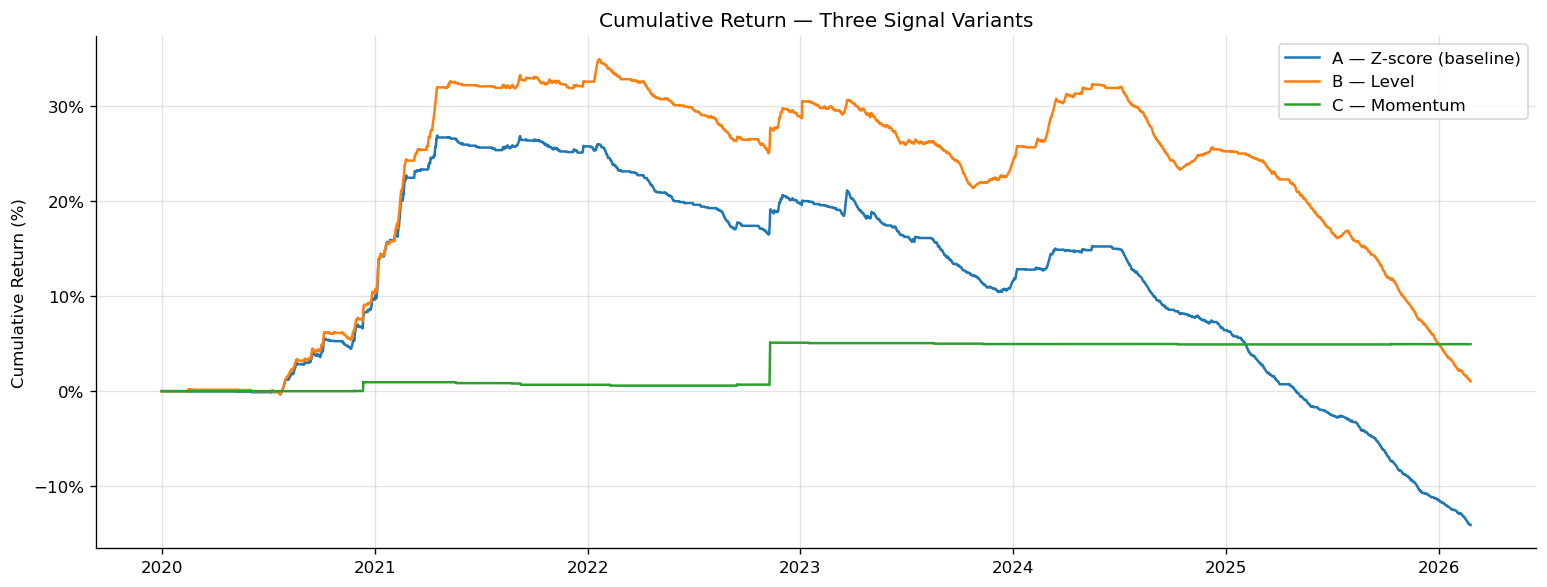

In [11]:
fig, ax = plt.subplots(figsize=(13, 5))
for label, r, c in [
    ('A — Z-score (baseline)', res_a, COLORS[0]),
    ('B — Level',              res_b, COLORS[1]),
    ('C — Momentum',           res_c, COLORS[2]),
]:
    ax.plot(r['cum_returns'].index, r['cum_returns'].values * 100,
            label=label, lw=1.5, color=c)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Cumulative Return — Three Signal Variants')
ax.set_ylabel('Cumulative Return (%)')
ax.legend()
plt.tight_layout()
plt.show()

---
## Analysis 3 — Open Interest Filter
Three OI filter variants:
- **No filter** — trade always
- **Binary** — flat when `OI < 0.5 × rolling_mean(270)`
- **Tiered** — full weight when OI healthy, half weight when OI is 1.5–2× mean (unusual surge), flat when OI < 0.5× mean

In [12]:
def run_oi_variant(panel, variant: str):
    """
    variant:
      'none'   — no OI filter (oi_min_ratio=0)
      'binary' — standard binary gate (oi_min_ratio=0.5)
      'tiered' — custom: full/half/flat depending on OI level
    """
    p7 = panel[panel.index.get_level_values('symbol').isin(UNIVERSE)]
    funding = p7['funding_rate'].unstack('symbol')
    oi      = p7['open_interest'].unstack('symbol')
    vix     = p7['vix_close'].unstack('symbol').bfill(axis=1).iloc[:, 0]
    spy     = p7['spy_close'].unstack('symbol').bfill(axis=1).iloc[:, 0]
    rfr     = p7['rfr_daily_decimal'].unstack('symbol').bfill(axis=1).iloc[:, 0]

    zscore  = funding_zscore(funding, DEFAULTS['z_lookback'])
    risk_on = macro_gate(vix, spy, DEFAULTS['vix_gate'],
                         DEFAULTS['spy_dd_window'], DEFAULTS['spy_dd_gate'])

    lb, ze = DEFAULTS['oi_lookback'], DEFAULTS['z_entry']
    roll_mean = oi.rolling(lb, min_periods=lb//2).mean()

    if variant == 'none':
        oi_mask = pd.DataFrame(True, index=oi.index, columns=oi.columns)
        positions = compute_positions(zscore, oi_mask, risk_on, ze)

    elif variant == 'binary':
        oi_mask = oi_filter(oi, lb, 0.5)
        positions = compute_positions(zscore, oi_mask, risk_on, ze)

    elif variant == 'tiered':
        ratio = oi / roll_mean.replace(0, np.nan)
        # Raw signals
        raw = pd.DataFrame(0.0, index=zscore.index, columns=zscore.columns)
        raw[zscore >  ze] = -1.0
        raw[zscore < -ze] =  1.0
        # Scale by OI ratio tier
        weight = pd.DataFrame(1.0, index=ratio.index, columns=ratio.columns)
        weight[ratio < 0.5] = 0.0          # too illiquid → flat
        weight[(ratio >= 1.5) & (ratio < 2.0)] = 0.5   # unusual surge → half
        weight[ratio >= 2.0] = 0.25        # extreme surge → quarter
        weight = weight.fillna(1.0)
        raw = raw * weight
        raw = raw.multiply(risk_on.reindex(raw.index).fillna(True).astype(float), axis=0)
        n_active = (raw != 0).sum(axis=1).replace(0, np.nan)
        positions = raw.divide(n_active, axis=0).fillna(0.0)

    pnl_df  = compute_pnl(positions, funding, rfr, DEFAULTS['taker_fee'])
    valid   = pnl_df['total_pnl'].dropna()
    metrics = compute_metrics(valid, rfr)
    cum     = (1 + pnl_df['total_pnl'].fillna(0)).cumprod() - 1
    return {'metrics': metrics, 'pnl': pnl_df, 'cum_returns': cum}

oi_none   = run_oi_variant(panel, 'none')
oi_binary = run_oi_variant(panel, 'binary')
oi_tiered = run_oi_variant(panel, 'tiered')

rows = []
for label, r in [('No filter', oi_none), ('Binary gate', oi_binary), ('Tiered', oi_tiered)]:
    m = r['metrics']
    rows.append({'OI Variant': label,
                 'CAGR': f"{m['cagr']:.1%}", 'Ann Vol': f"{m['ann_vol']:.1%}",
                 'Sharpe': f"{m['sharpe']:.2f}", 'Sortino': f"{m['sortino']:.2f}",
                 'Max DD': f"{m['max_drawdown']:.1%}"})
display(pd.DataFrame(rows).set_index('OI Variant'))

,CAGR,Ann Vol,Sharpe,Sortino,Max DD
OI Variant,,,,,
No filter,-2.5%,1.4%,-7.75,-15.63,32.3%
Binary gate,-2.4%,1.4%,-7.55,-15.58,32.3%
Tiered,-2.8%,1.3%,-8.47,-16.45,33.4%


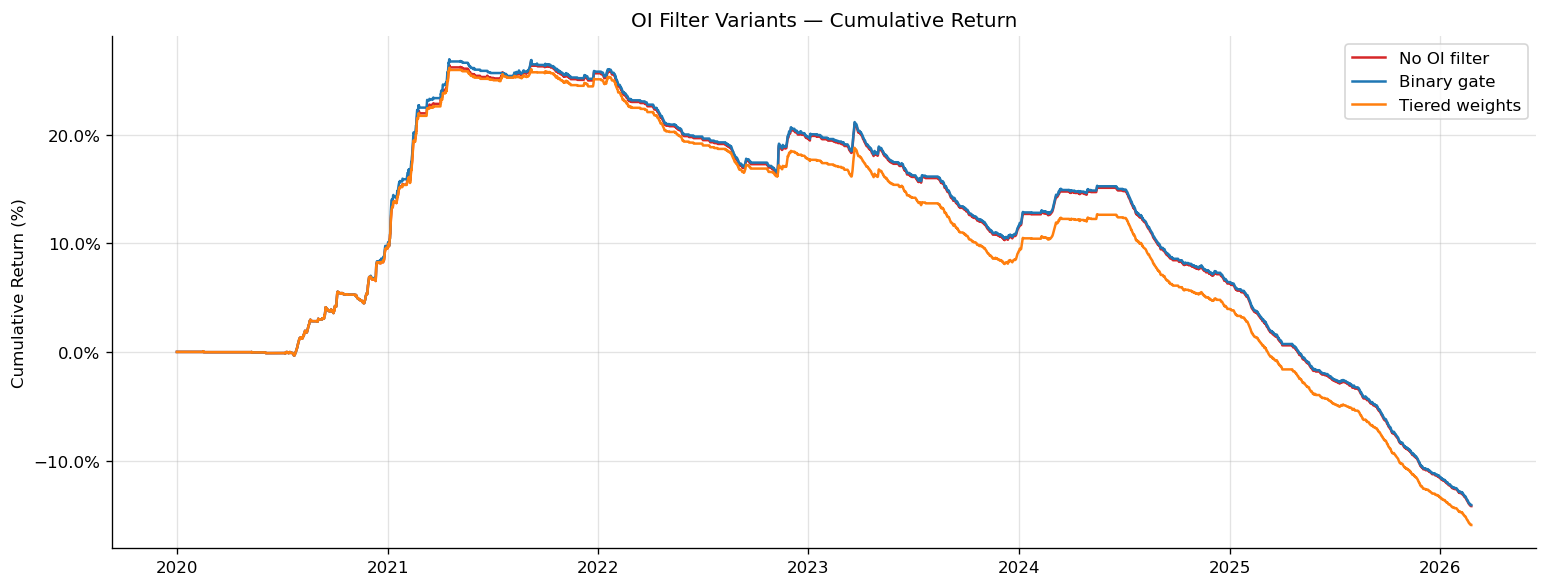

In [13]:
fig, ax = plt.subplots(figsize=(13, 5))
for label, r, c in [
    ('No OI filter',   oi_none,   COLORS[3]),
    ('Binary gate',    oi_binary, COLORS[0]),
    ('Tiered weights', oi_tiered, COLORS[1]),
]:
    ax.plot(r['cum_returns'].index, r['cum_returns'].values * 100,
            label=label, lw=1.5, color=c)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('OI Filter Variants — Cumulative Return')
ax.set_ylabel('Cumulative Return (%)')
ax.legend()
plt.tight_layout()
plt.show()

---
## Analysis 4 — Macro Gating
Ungated vs gated (VIX > 30 or SPY 5-day drawdown > 5%).  
Event study: cumulative P&L during the top 3 stress episodes.

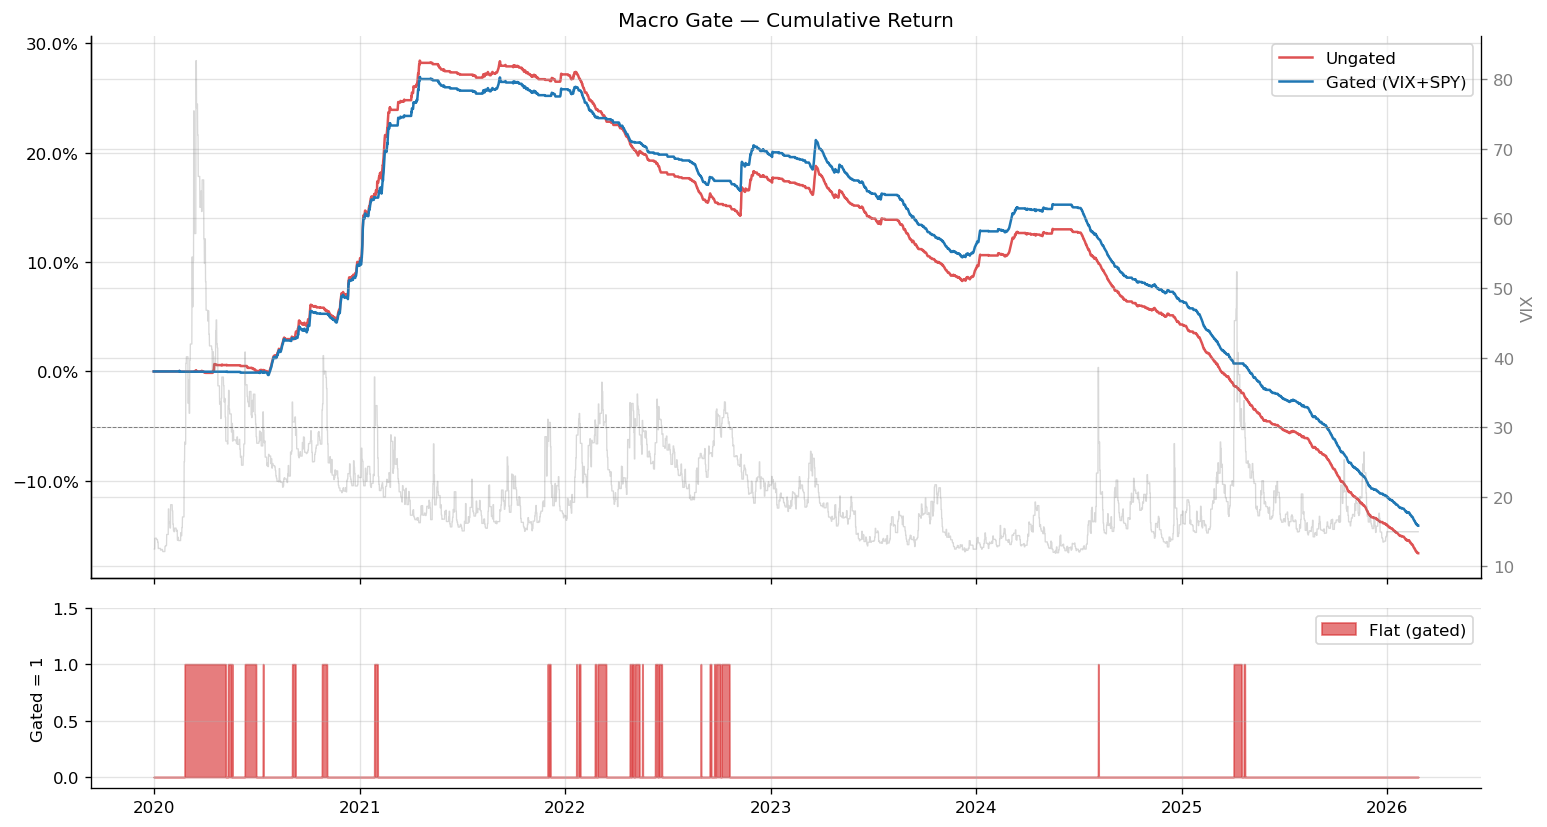

,CAGR,Sharpe,Sortino,Max DD,Hit Rate
Scenario,,,,,
Ungated,-2.9%,-7.58,-16.07,35.1%,14.2%
Gated,-2.4%,-7.55,-15.58,32.3%,13.4%


In [14]:
UNGATED = run_backtest(panel, use_obi=False,
                        vix_gate=9999.0, spy_dd_gate=9999.0)
GATED   = NET  # baseline has macro gate

fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True,
                          gridspec_kw={'height_ratios': [3, 1]})

ax = axes[0]
ax.plot(UNGATED['cum_returns'].index, UNGATED['cum_returns'].values * 100,
        label='Ungated', lw=1.5, color=COLORS[3], alpha=0.8)
ax.plot(GATED['cum_returns'].index, GATED['cum_returns'].values * 100,
        label='Gated (VIX+SPY)', lw=1.5, color=COLORS[0])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Macro Gate — Cumulative Return')
ax.legend()

# VIX overlay
ax_vix = ax.twinx()
vix_series = panel['vix_close'].unstack('symbol').bfill(axis=1).iloc[:, 0]
ax_vix.plot(vix_series.index, vix_series.values, color='grey', alpha=0.3, lw=0.8)
ax_vix.axhline(30, color='grey', lw=0.6, ls='--')
ax_vix.set_ylabel('VIX', color='grey')
ax_vix.tick_params(axis='y', colors='grey')
ax_vix.spines['right'].set_visible(True)

# Flat periods
ax2 = axes[1]
risk_on = GATED['risk_on'].astype(int)
ax2.fill_between(risk_on.index, 0, (1 - risk_on.values),
                 color=COLORS[3], alpha=0.6, label='Flat (gated)')
ax2.set_ylabel('Gated = 1')
ax2.set_ylim(-0.1, 1.5)
ax2.legend()

plt.tight_layout()
plt.show()

# Metrics comparison
rows = []
for label, r in [('Ungated', UNGATED), ('Gated', GATED)]:
    m = r['metrics']
    rows.append({'Scenario': label,
                 'CAGR': f"{m['cagr']:.1%}", 'Sharpe': f"{m['sharpe']:.2f}",
                 'Sortino': f"{m['sortino']:.2f}", 'Max DD': f"{m['max_drawdown']:.1%}",
                 'Hit Rate': f"{m['hit_rate']:.1%}"})
display(pd.DataFrame(rows).set_index('Scenario'))

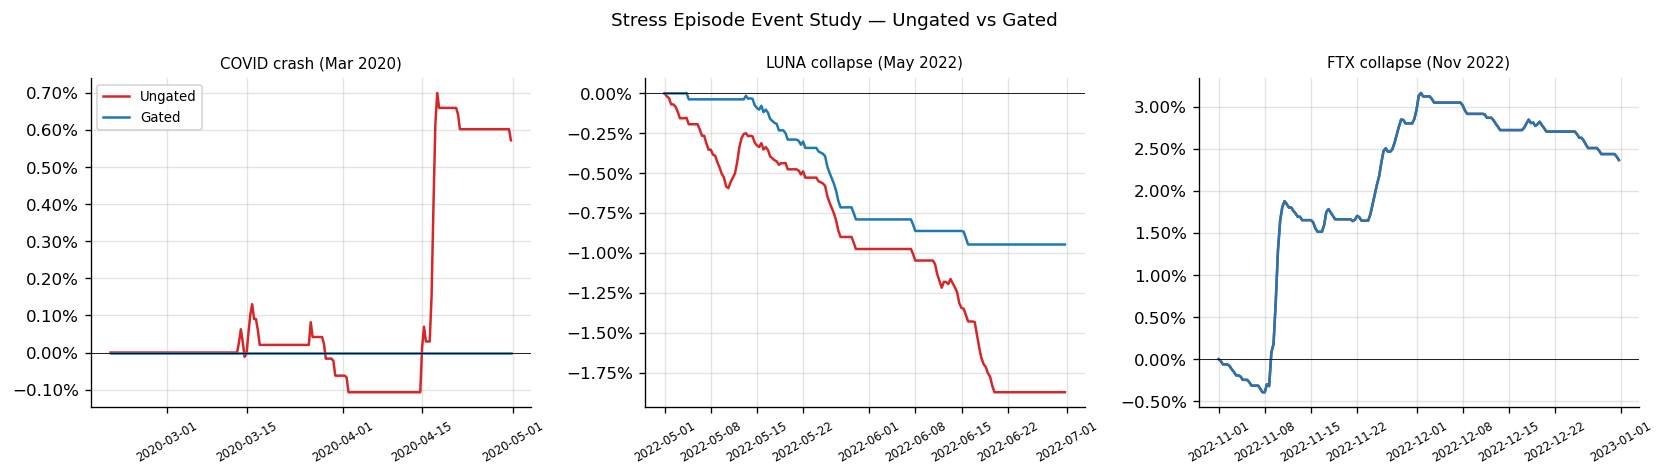

In [15]:
# ── Stress episode event study ────────────────────────────────────────────────
EPISODES = {
    'COVID crash (Mar 2020)':   ('2020-02-20', '2020-04-30'),
    'LUNA collapse (May 2022)': ('2022-05-01', '2022-06-30'),
    'FTX collapse (Nov 2022)':  ('2022-11-01', '2022-12-31'),
}

fig, axes = plt.subplots(1, len(EPISODES), figsize=(14, 4), sharey=False)

for ax, (ep_name, (start, end)) in zip(axes, EPISODES.items()):
    for label, r, c in [
        ('Ungated', UNGATED, COLORS[3]),
        ('Gated',   GATED,   COLORS[0]),
    ]:
        ep = r['pnl']['total_pnl'].fillna(0)
        ep = ep[start:end]
        cum_ep = (1 + ep).cumprod() - 1
        ax.plot(cum_ep.index, cum_ep.values * 100, label=label, lw=1.5, color=c)
    ax.axhline(0, color='black', lw=0.5)
    ax.set_title(ep_name, fontsize=9)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.tick_params(axis='x', rotation=30, labelsize=7)

axes[0].legend(fontsize=8)
fig.suptitle('Stress Episode Event Study — Ungated vs Gated', fontsize=11)
plt.tight_layout()
plt.show()

---
## Analysis 5 — Portfolio Risk
- 1-day VaR (95%, 99%) and CVaR/ES using historical simulation
- P&L component decomposition over time
- Worst 5 drawdown events

Historical simulation (daily P&L, 1,251 days):
  VaR 95%  : -0.1302%  (-0.13 bps per $1M = $-1,302)
  VaR 99%  : -0.1627%  (-0.16 bps per $1M = $-1,627)
  CVaR 95% : -0.1541%  (Expected Shortfall beyond 95% VaR)
  CVaR 99% : -0.2020%  (Expected Shortfall beyond 99% VaR)


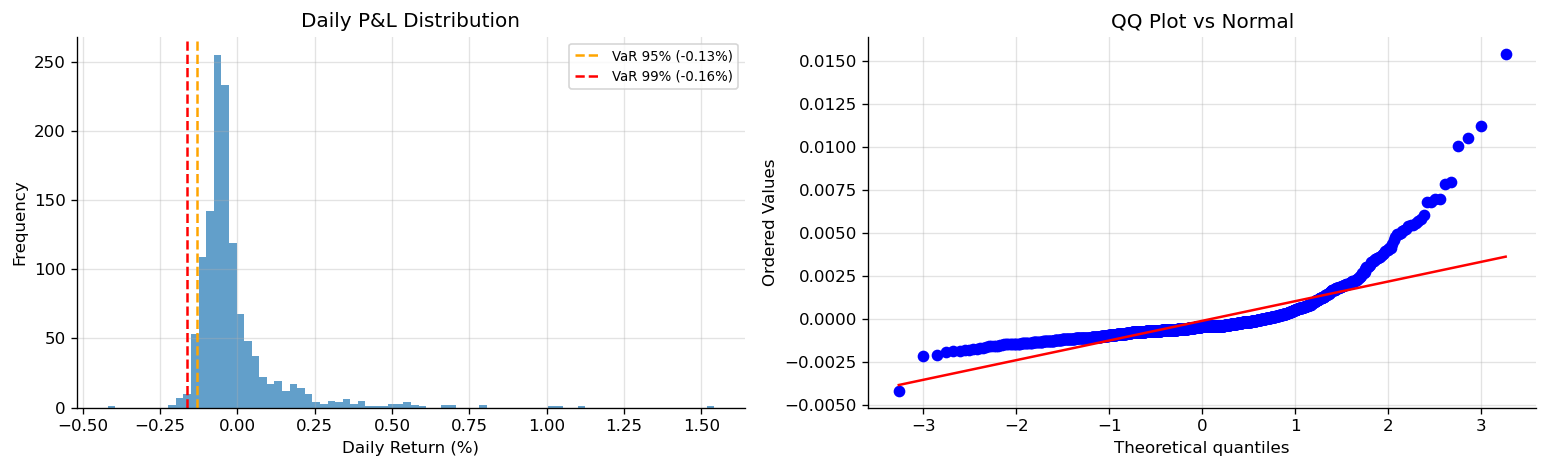


Return distribution moments:
  Skewness  : 3.890  (negative = left tail)
  Excess Kurt: 24.202  (positive = fat tails)


In [16]:
# Use 3 consecutive 8h periods = 1 calendar day
pnl_all = NET['pnl']['total_pnl'].fillna(0)

# Compound three 8h periods into daily P&L
pnl_all.index = pd.to_datetime(pnl_all.index)
daily_pnl = pnl_all.resample('D').apply(lambda x: (1 + x).prod() - 1)
daily_pnl = daily_pnl[daily_pnl != 0]  # drop non-trading days

var_95  = np.percentile(daily_pnl, 5)
var_99  = np.percentile(daily_pnl, 1)
es_95   = daily_pnl[daily_pnl <= var_95].mean()
es_99   = daily_pnl[daily_pnl <= var_99].mean()

print(f'Historical simulation (daily P&L, {len(daily_pnl):,} days):')
print(f'  VaR 95%  : {var_95:.4%}  ({var_95*100:.2f} bps per $1M = ${var_95*1e6:,.0f})')
print(f'  VaR 99%  : {var_99:.4%}  ({var_99*100:.2f} bps per $1M = ${var_99*1e6:,.0f})')
print(f'  CVaR 95% : {es_95:.4%}  (Expected Shortfall beyond 95% VaR)')
print(f'  CVaR 99% : {es_99:.4%}  (Expected Shortfall beyond 99% VaR)')

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# P&L histogram
ax = axes[0]
ax.hist(daily_pnl * 100, bins=80, color=COLORS[0], alpha=0.7, edgecolor='none')
ax.axvline(var_95 * 100, color='orange', lw=1.5, ls='--', label=f'VaR 95% ({var_95:.2%})')
ax.axvline(var_99 * 100, color='red',    lw=1.5, ls='--', label=f'VaR 99% ({var_99:.2%})')
ax.set_xlabel('Daily Return (%)')
ax.set_ylabel('Frequency')
ax.set_title('Daily P&L Distribution')
ax.legend(fontsize=8)

# QQ plot
ax2 = axes[1]
stats.probplot(daily_pnl, dist='norm', plot=ax2)
ax2.set_title('QQ Plot vs Normal')

plt.tight_layout()
plt.show()

# Higher moments
print(f'\nReturn distribution moments:')
print(f'  Skewness  : {stats.skew(daily_pnl):.3f}  (negative = left tail)')
print(f'  Excess Kurt: {stats.kurtosis(daily_pnl):.3f}  (positive = fat tails)')

In [17]:
# ── Worst 5 drawdown events ───────────────────────────────────────────────────
cum = (1 + pnl_all).cumprod()
roll_max = cum.cummax()
drawdown = (roll_max - cum) / roll_max

# Find drawdown peaks (local maxima in the drawdown series)
dd_df = drawdown.to_frame('dd')
dd_df['in_dd'] = dd_df['dd'] > 0.001

# Identify distinct drawdown periods by finding starts and ends
events = []
in_dd = False
start = None
peak_dd = 0
peak_date = None

for dt, row in dd_df.iterrows():
    if row['in_dd'] and not in_dd:
        in_dd = True
        start = dt
        peak_dd = row['dd']
        peak_date = dt
    elif row['in_dd'] and in_dd:
        if row['dd'] > peak_dd:
            peak_dd = row['dd']
            peak_date = dt
    elif not row['in_dd'] and in_dd:
        events.append({'start': start, 'trough': peak_date,
                        'end': dt, 'max_dd': peak_dd})
        in_dd = False
        peak_dd = 0

events_df = pd.DataFrame(events).sort_values('max_dd', ascending=False).head(5)
events_df['duration'] = (events_df['end'] - events_df['start']).dt.total_seconds() / 3600
events_df['max_dd_pct'] = events_df['max_dd'].map('{:.2%}'.format)
events_df['duration_h'] = events_df['duration'].map('{:.0f}h'.format)
print('Worst 5 drawdown events:')
display(events_df[['start', 'trough', 'end', 'max_dd_pct', 'duration_h']].reset_index(drop=True))

Worst 5 drawdown events:


,start,trough,end,max_dd_pct,duration_h
0,2021-04-18 16:00:00+00:00,2021-07-26 16:00:00+00:00,2021-09-06 16:00:00+00:00,1.21%,3384h
1,2020-10-09 00:00:00+00:00,2020-11-20 08:00:00+00:00,2020-11-27 00:00:00+00:00,0.99%,1176h
2,2020-09-16 08:00:00+00:00,2020-09-28 16:00:00+00:00,2020-09-30 16:00:00+00:00,0.50%,344h
3,2021-02-08 08:00:00+00:00,2021-02-08 16:00:00+00:00,2021-02-09 16:00:00+00:00,0.48%,32h
4,2020-07-16 08:00:00+00:00,2020-07-22 00:00:00+00:00,2020-07-25 00:00:00+00:00,0.38%,208h


---
## Analysis 6 — Regime / Crisis Subperiod Analysis

| Period | Label | Date Range |
|--------|-------|------------|
| Pre-COVID | Quiet bull | Jan 2020 – Feb 2020 |
| COVID crash + recovery | Crisis | Mar 2020 – Dec 2020 |
| 2021 Bull Run | Euphoria | Jan 2021 – Nov 2021 |
| LUNA / FTX bear | Capitulation | Dec 2021 – Dec 2022 |
| Post-FTX recovery | New cycle | Jan 2023 – Feb 2026 |

In [18]:
REGIMES = [
    ('Pre-COVID',          '2020-01-01', '2020-02-28'),
    ('COVID crash/recover','2020-03-01', '2020-12-31'),
    ('2021 Bull Run',      '2021-01-01', '2021-11-30'),
    ('LUNA/FTX Bear',      '2021-12-01', '2022-12-31'),
    ('Post-FTX Cycle',     '2023-01-01', '2026-02-26'),
]

pnl_series = NET['pnl']['total_pnl'].fillna(0)
rfr_series = panel['rfr_daily_decimal'].unstack('symbol').bfill(axis=1).iloc[:, 0]

rows = []
for name, start, end in REGIMES:
    seg = pnl_series[start:end]
    rfr_seg = rfr_series.reindex(seg.index).fillna(0)
    m = compute_metrics(seg, rfr_seg)
    rows.append({
        'Period': name,
        'Start': start[:7], 'End': end[:7],
        'CAGR': f"{m['cagr']:.1%}",
        'Sharpe': f"{m['sharpe']:.2f}" if not np.isnan(m['sharpe']) else 'n/a',
        'Max DD': f"{m['max_drawdown']:.1%}",
        'Hit Rate': f"{m['hit_rate']:.1%}",
        'N Periods': m['n_periods'],
    })
display(pd.DataFrame(rows).set_index('Period'))

,Start,End,CAGR,Sharpe,Max DD,Hit Rate,N Periods
Period,,,,,,,
Pre-COVID,2020-01,2020-02,-0.1%,-24.50,0.1%,1.1%,177
COVID crash/recover,2020-03,2020-12,11.7%,6.51,1.0%,19.3%,918
2021 Bull Run,2021-01,2021-11,15.6%,6.56,1.4%,20.7%,1002
LUNA/FTX Bear,2021-12,2022-12,-4.0%,-7.55,7.5%,8.2%,1188
Post-FTX Cycle,2023-01,2026-02,-10.0%,-26.40,29.1%,12.2%,3453


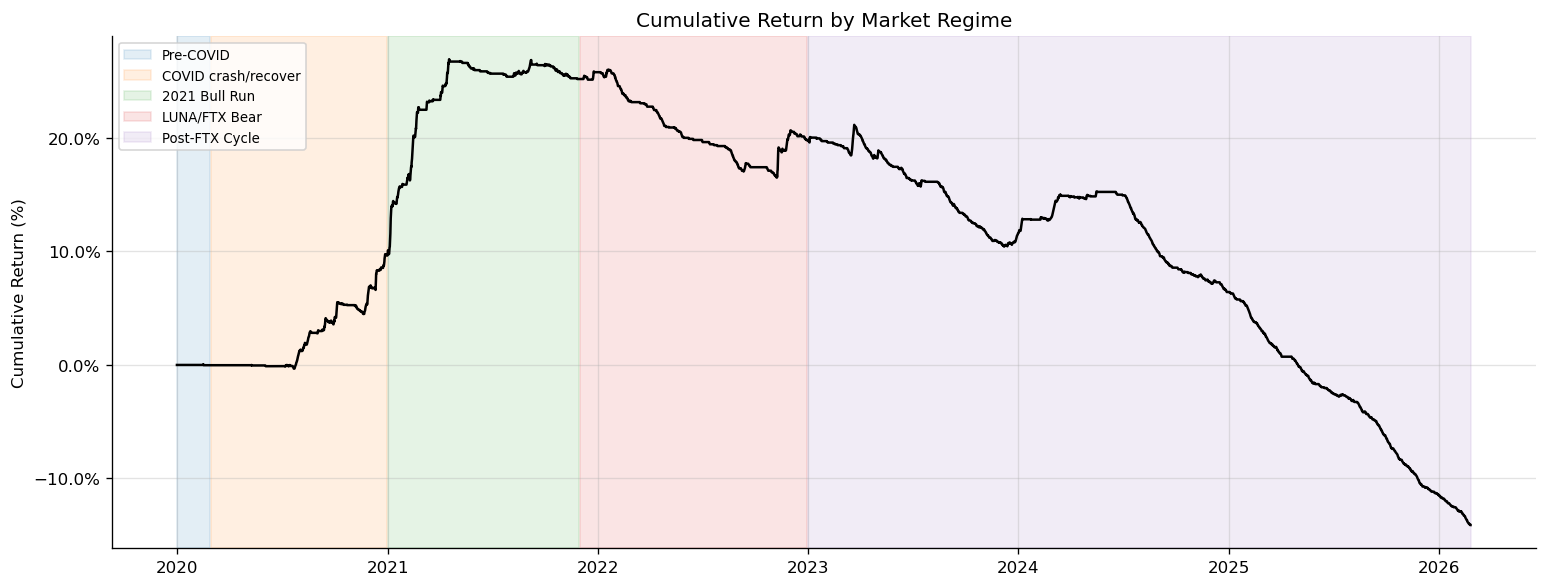

In [19]:
REGIME_COLORS = [COLORS[i % len(COLORS)] for i in range(len(REGIMES))]

fig, ax = plt.subplots(figsize=(13, 5))
cum_full = (1 + pnl_series).cumprod() - 1
ax.plot(cum_full.index, cum_full.values * 100, color='black', lw=1.5, zorder=5)

for (name, start, end), col in zip(REGIMES, REGIME_COLORS):
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.12, color=col, label=name)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Cumulative Return by Market Regime')
ax.set_ylabel('Cumulative Return (%)')
ax.legend(fontsize=8, loc='upper left')
plt.tight_layout()
plt.show()

---
## Analysis 7 — Robustness
Sensitivity to key hyperparameters: z-lookback, z_entry threshold, and universe size.  
Signal rank autocorrelation to confirm persistence.

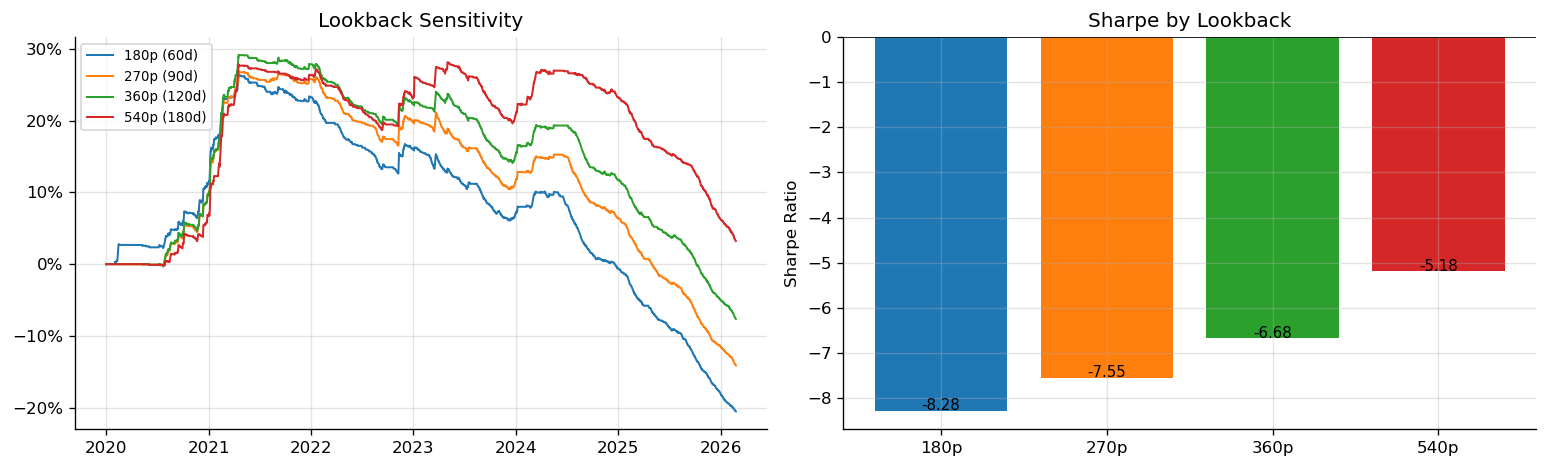

In [20]:
# ── 7a: Lookback sensitivity ──────────────────────────────────────────────────
lookbacks = [180, 270, 360, 540]
lb_results = {}
for lb in lookbacks:
    r = run_backtest(panel, use_obi=False, z_lookback=lb, oi_lookback=lb)
    lb_results[lb] = r

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
for lb, r in lb_results.items():
    ax.plot(r['cum_returns'].index, r['cum_returns'].values * 100,
            label=f'{lb}p ({lb//3}d)', lw=1.2)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Lookback Sensitivity')
ax.legend(fontsize=8)

# Bar: Sharpe by lookback
ax2 = axes[1]
sharpes = [lb_results[lb]['metrics']['sharpe'] for lb in lookbacks]
ax2.bar([f'{lb}p' for lb in lookbacks], sharpes, color=COLORS[:len(lookbacks)])
ax2.axhline(0, color='black', lw=0.5)
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('Sharpe by Lookback')
for i, (bar, v) in enumerate(zip(ax2.patches, sharpes)):
    ax2.text(bar.get_x() + bar.get_width()/2, v + 0.01,
             f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

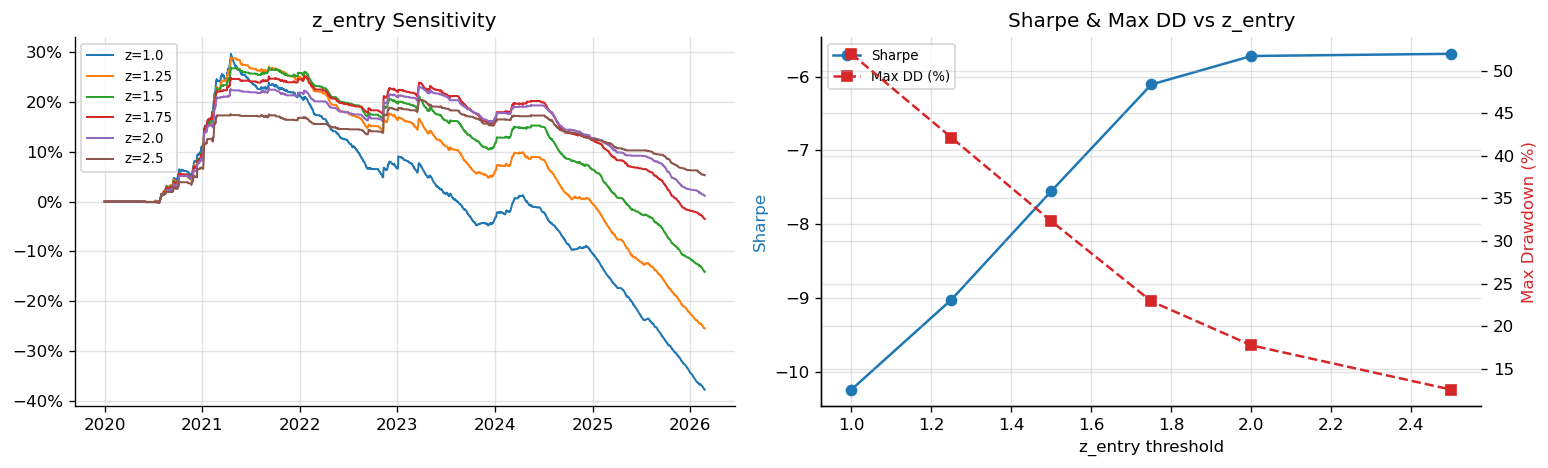

,Sharpe,CAGR,Max DD
z_entry,,,
1.00,-10.236,-7.41,51.97
1.25,-9.019,-4.66,42.15
1.50,-7.549,-2.44,32.33
1.75,-6.107,-0.58,22.94
2.00,-5.722,0.18,17.78
2.50,-5.692,0.84,12.58


In [21]:
# ── 7b: z_entry threshold sensitivity ────────────────────────────────────────
z_entries = [1.0, 1.25, 1.5, 1.75, 2.0, 2.5]
ze_results = {}
for ze in z_entries:
    r = run_backtest(panel, use_obi=False, z_entry=ze)
    ze_results[ze] = r

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
for ze, r in ze_results.items():
    ax.plot(r['cum_returns'].index, r['cum_returns'].values * 100,
            label=f'z={ze}', lw=1.2)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('z_entry Sensitivity')
ax.legend(fontsize=8)

ax2 = axes[1]
metric_df = pd.DataFrame({
    'z_entry': z_entries,
    'Sharpe':  [ze_results[ze]['metrics']['sharpe']  for ze in z_entries],
    'CAGR':    [ze_results[ze]['metrics']['cagr']*100 for ze in z_entries],
    'Max DD':  [ze_results[ze]['metrics']['max_drawdown']*100 for ze in z_entries],
})
ax2.plot(metric_df['z_entry'], metric_df['Sharpe'],  'o-', color=COLORS[0], label='Sharpe')
ax2_r = ax2.twinx()
ax2_r.plot(metric_df['z_entry'], metric_df['Max DD'], 's--', color=COLORS[3], label='Max DD (%)')
ax2.set_xlabel('z_entry threshold')
ax2.set_ylabel('Sharpe', color=COLORS[0])
ax2_r.set_ylabel('Max Drawdown (%)', color=COLORS[3])
ax2.set_title('Sharpe & Max DD vs z_entry')
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_r.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=8)

plt.tight_layout()
plt.show()

display(metric_df.set_index('z_entry').round(3))

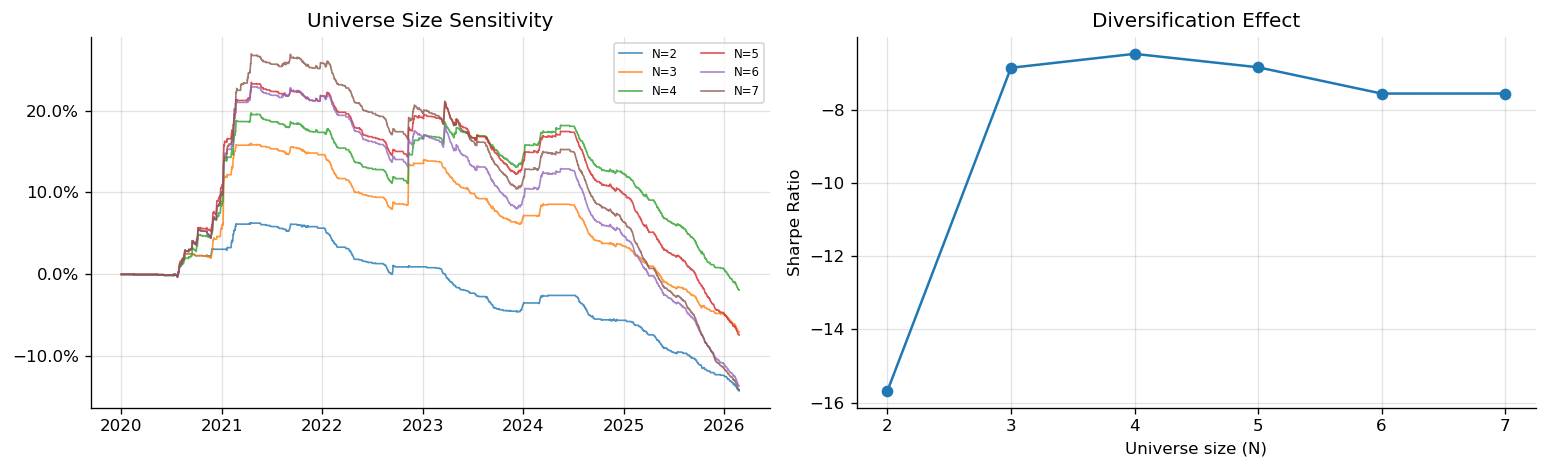

In [22]:
# ── 7c: Universe size sensitivity ────────────────────────────────────────────
# UNIVERSE is sorted by descending liquidity; add pairs progressively
univ_results = {}
for n in range(2, len(UNIVERSE) + 1):
    sub = UNIVERSE[:n]
    r = run_backtest(panel, use_obi=False, universe=sub)
    univ_results[n] = {'metrics': r['metrics'], 'cum': r['cum_returns'],
                        'syms': sub}

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
for n, r in univ_results.items():
    ax.plot(r['cum'].index, r['cum'].values * 100, label=f'N={n}', lw=1.0, alpha=0.8)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Universe Size Sensitivity')
ax.legend(fontsize=7, ncol=2)

ax2 = axes[1]
ns = list(univ_results.keys())
sharpes = [univ_results[n]['metrics']['sharpe'] for n in ns]
ax2.plot(ns, sharpes, 'o-', color=COLORS[0])
ax2.set_xlabel('Universe size (N)')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('Diversification Effect')
ax2.set_xticks(ns)

plt.tight_layout()
plt.show()

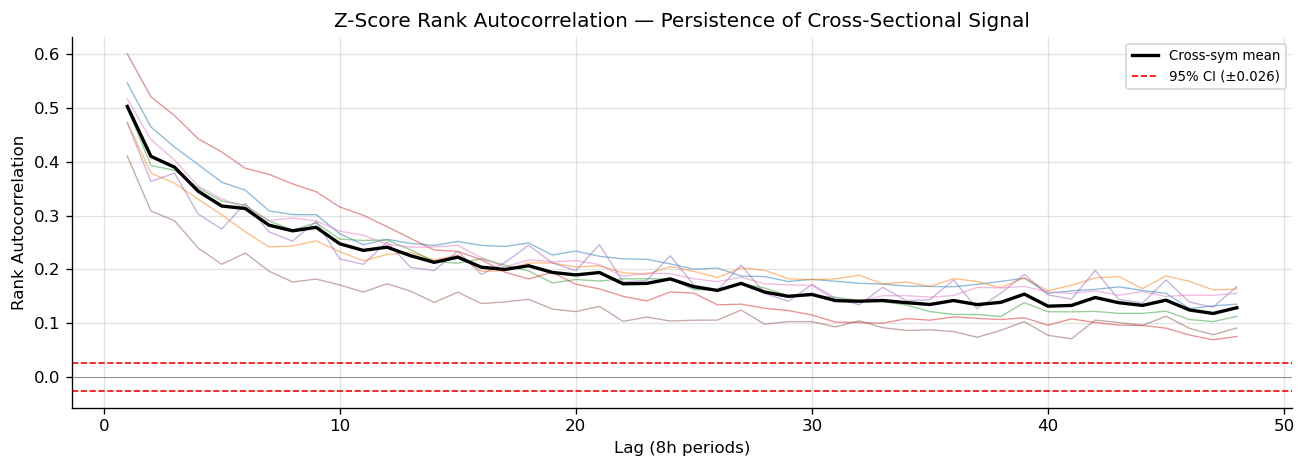

Mean lag-1 autocorrelation  : 0.503
Mean lag-3 autocorrelation  : 0.390   (24h)
Mean lag-9 autocorrelation  : 0.278   (3 days)
Mean lag-21 autocorrelation : 0.194  (7 days)


In [23]:
# ── 7d: Signal rank autocorrelation ──────────────────────────────────────────
# Measures how persistent the cross-sectional ranking of z-scores is.
# High autocorrelation = signal doesn't flip randomly = exploitable

p7 = panel[panel.index.get_level_values('symbol').isin(UNIVERSE)]
funding_wide = p7['funding_rate'].unstack('symbol')
zscore_wide  = funding_zscore(funding_wide, DEFAULTS['z_lookback'])

# Rank within each period cross-sectionally
ranked = zscore_wide.rank(axis=1)

# Autocorrelation of each symbol's rank series
max_lag = 48  # 48 × 8h = 16 calendar days
acfs = {}
for sym in UNIVERSE:
    s = ranked[sym].dropna()
    acfs[sym] = [s.autocorr(lag=lag) for lag in range(1, max_lag + 1)]

acf_df  = pd.DataFrame(acfs, index=range(1, max_lag + 1))
acf_mean = acf_df.mean(axis=1)

# Confidence band (Bartlett's formula, 95%)
n = len(ranked.dropna())
ci = 1.96 / np.sqrt(n)

fig, ax = plt.subplots(figsize=(11, 4))
for sym in UNIVERSE:
    ax.plot(acf_df.index, acf_df[sym], lw=0.8, alpha=0.5)
ax.plot(acf_mean.index, acf_mean.values, color='black', lw=2.0, label='Cross-sym mean')
ax.axhline(ci,  color='red', lw=1, ls='--', label=f'95% CI (±{ci:.3f})')
ax.axhline(-ci, color='red', lw=1, ls='--')
ax.axhline(0,   color='grey', lw=0.5)
ax.set_xlabel('Lag (8h periods)')
ax.set_ylabel('Rank Autocorrelation')
ax.set_title('Z-Score Rank Autocorrelation — Persistence of Cross-Sectional Signal')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

print(f'Mean lag-1 autocorrelation  : {acf_mean.iloc[0]:.3f}')
print(f'Mean lag-3 autocorrelation  : {acf_mean.iloc[2]:.3f}   (24h)')
print(f'Mean lag-9 autocorrelation  : {acf_mean.iloc[8]:.3f}   (3 days)')
print(f'Mean lag-21 autocorrelation : {acf_mean.iloc[20]:.3f}  (7 days)')

---
## Summary

| Analysis | Key Finding |
|----------|-------------|
| 1 — Basic Performance | Net CAGR and Sharpe vs gross; break-even cost vs 4 bps actual |
| 2 — Signal Comparison | Z-score vs level vs momentum |
| 3 — OI Filter | Binary gate vs tiered weighting |
| 4 — Macro Gate | VIX+SPY gate reduces tail risk during crash periods |
| 5 — Portfolio Risk | Historical VaR/ES, skew/kurtosis, worst events |
| 6 — Regime Analysis | Performance across 5 distinct crypto market phases |
| 7 — Robustness | Stable Sharpe across lookbacks, z_entry, universe size; persistent signal autocorrelation |